In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from acquire import get_titanic_data
from prepare import prep_split_titanic_drp_age,prep_split_titanic_imp_age,prep_split_titanic_drp_null_age
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Logistic Regression

What is it?
- a machine learning algorithm used for predicting categorical target variables
- Pipeline: Plan - Acquire - Prepare - Explore - **Model** - Deliver

Why do we care?
- we can predict future target variables based on the model we build! 

How do we use it?
- acquire, prepare, explore our data
- split data for modeling
- build models on train
    - create rules based on our input data
- evaluate models on train & validate
    - see how our rules work on unseen data
- pick best of the best model, and evaluate bestest model on test

### change hyperparameter
#### Regularization:
- Keep model simple
- Constraints the coefficients


#### C = Inverse of regularization strength:

- Lower C is higher regularization
- Lower C discourages learning more complex model

## Exercises
work with `titanic` data

In [2]:
df = get_titanic_data()
# tr,v,t = prep_split_titanic_drp_age(df)
# tr,v,t = prep_split_titanic_imp_age(df)
tr,v,t = prep_split_titanic_drp_null_age(df)
tr.sample()

csv file found and loaded
data cleaned and prepped
data split
train -> (428, 12); 59.94%
validate -> (143, 12); 20.03%
test -> (143, 12); 20.03%


,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S
605,0,3,male,36.0,1,0,15.55,S,0,1,0,1


In [3]:
Xtr = tr.drop(columns=['survived','sex','embarked'])
Xv = v.drop(columns=['survived','sex','embarked'])
Xt = t.drop(columns=['survived','sex','embarked'])
ytr = tr.survived
yv = v.survived
yt = t.survived

In [4]:
# 0 (not survived) most common
# drp_null_age baseline = 0.5934579439252337
def baseline(ytr):
    b = (ytr==ytr.value_counts().idxmax()).mean()
    return b, ytr.value_counts().idxmax()
baseline(ytr)

(0.5934579439252337, 0)

### 1. Create a model that includes only age, fare, and pclass. Does this model perform better than your baseline?



In [5]:
features = ['age','fare','pclass']

In [6]:
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])

In [7]:
l.coef_,Xtr[features].columns

(array([[-0.04438556,  0.00750615, -1.04081893]]),
 Index(['age', 'fare', 'pclass'], dtype='object'))

In [8]:
l.score(Xtr[features],ytr)

0.7149532710280374

In [9]:
def cmd(ytr,y_pred,labels=l.classes_):
    ConfusionMatrixDisplay(confusion_matrix(ytr,y_pred,labels=labels),display_labels=labels).plot()
    plt.show()

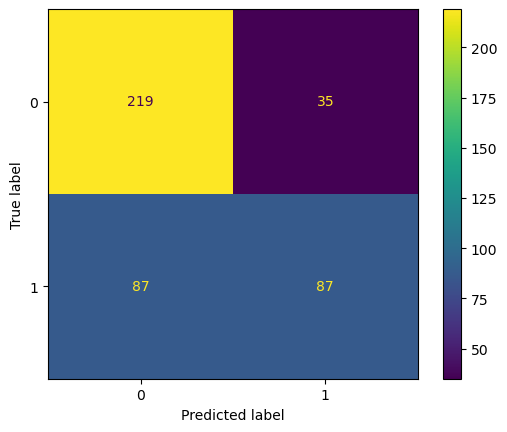

In [10]:
cmd(ytr,ytr_pred)

In [11]:
pd.DataFrame(classification_report(ytr,ytr_pred,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.715686,0.713115,0.714953,0.714401,0.714641
recall,0.862205,0.500000,0.714953,0.681102,0.714953
f1-score,0.782143,0.587838,0.714953,0.684990,0.703150
support,254.000000,174.000000,0.714953,428.000000,428.000000


In [12]:
# drp_null_age baseline acc = 0.5934579439252337
# drp_null_age[age,fare,pclass] acc = 0.7149532710280374
baseline(ytr),l.score(Xtr[features],ytr)

((0.5934579439252337, 0), 0.7149532710280374)

### 2. Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.



In [13]:
features = ['age','fare','pclass','sex_male']

In [14]:
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])

In [15]:
l.coef_,Xtr[features].columns

(array([[-0.03940784,  0.00325799, -1.09151249, -2.2331381 ]]),
 Index(['age', 'fare', 'pclass', 'sex_male'], dtype='object'))

In [16]:
l.score(Xtr[features],ytr)

0.8037383177570093

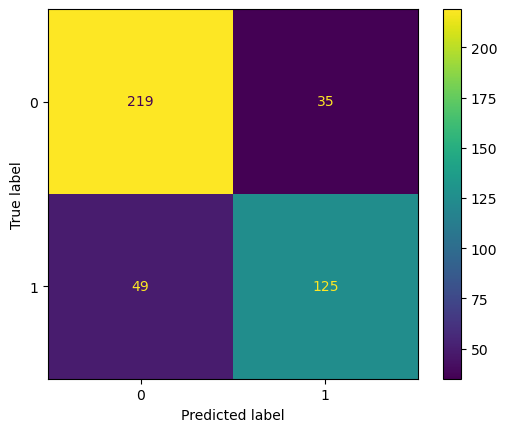

In [17]:
cmd(ytr,ytr_pred)

In [18]:
pd.DataFrame(classification_report(ytr,ytr_pred,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.817164,0.781250,0.803738,0.799207,0.802564
recall,0.862205,0.718391,0.803738,0.790298,0.803738
f1-score,0.839080,0.748503,0.803738,0.793792,0.802257
support,254.000000,174.000000,0.803738,428.000000,428.000000


In [19]:
# drp_null_age baseline acc = 0.5934579439252337
# drp_null_age[age,fare,pclass,sex_male] acc = 0.8037383177570093
baseline(ytr),l.score(Xtr[features],ytr)

((0.5934579439252337, 0), 0.8037383177570093)

### 3. Try out other combinations of features and models.



In [20]:
import itertools

In [21]:
def feature_combos(Xtr,ytr,max_iter=100):
    metrics = []
    iterable = Xtr.columns.to_list()
    for r in range(2,(len(iterable)+1)):
        for feature in itertools.combinations(iterable,r):
            f = list(feature)
            l = LogisticRegression(random_state=42,max_iter=max_iter)
            l.fit(Xtr[f],ytr)
            ytr_score = l.score(Xtr[f],ytr)
            # table-ize
            output = {
                'features':f,
                'train_score':ytr_score,
            }
            metrics.append(output)
    return pd.DataFrame(metrics)

In [22]:
df = feature_combos(Xtr,ytr,250)

In [23]:
f = df.sort_values('train_score',ascending=False).head(3)['features']
f

463    [pclass, age, sibsp, parch, alone, sex_male, e...
376         [pclass, age, sibsp, parch, alone, sex_male]
496    [pclass, age, sibsp, parch, alone, sex_male, e...
Name: features, dtype: object

In [24]:
f[463]

['pclass', 'age', 'sibsp', 'parch', 'alone', 'sex_male', 'embarked_S']

In [25]:
f[376]

['pclass', 'age', 'sibsp', 'parch', 'alone', 'sex_male']

In [26]:
f[496]

['pclass',
 'age',
 'sibsp',
 'parch',
 'alone',
 'sex_male',
 'embarked_Q',
 'embarked_S']

### 4. Use you best 3 models to predict and evaluate on your validate sample.



In [27]:
metrics = []
for i in [f[376],f[463],f[496]]:
    l = LogisticRegression(random_state=42,max_iter=250)
    l.fit(Xtr[i],ytr)
    ytr_score = l.score(Xtr[i],ytr)
    yv_score = l.score(Xv[i],yv)
    # table-ize
    output = {
        'features':i,
        'train_score':ytr_score,
        'val_score':yv_score,
    }
    metrics.append(output)
pd.DataFrame(metrics)

,features,train_score,val_score
0,"[pclass, age, sibsp, parch, alone, sex_male]",0.813084,0.783217
1,"[pclass, age, sibsp, parch, alone, sex_male, e...",0.813084,0.790210
2,"[pclass, age, sibsp, parch, alone, sex_male, e...",0.813084,0.790210


### 5. Choose you best model from the validation performance, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

In [28]:
def l_scores(Xtr, ytr, Xv, yv, c=None, max_iter=100):
    if c is None:
        c = [.01,.1,1,10,100,1000]
    #define variables
    metrics = []
    iterable = Xtr.columns.to_list()
    for r in range(2,(len(iterable)+1)):
        # for feature in itertools.combinations(iterable,r):
        for feature,c_val in itertools.product(itertools.combinations(iterable,r),c):
            f = list(feature)
            l = LogisticRegression(C=c_val,random_state=42,max_iter=max_iter)
            l.fit(Xtr[f],ytr)
            ytr_score = l.score(Xtr[f],ytr)
            yv_score = l.score(Xv[f],yv)
            # table-ize
            output = {
                'features':f,
                'c_value':c_val,
                'train_score':ytr_score,
                'val_score':yv_score,
            }
            metrics.append(output)
    #Put results into a dataframe
    df = pd.DataFrame(metrics)
    # Calculate the difference between the train and validation scores
    df['diff_score'] = abs(df.train_score - df.val_score)
    df['avg_score'] = (df.train_score + df.val_score)/2
    return df

def score_plot(data, diff=0.1, score='avg_score', score_v=.7):
    df = data[(data.diff_score<diff)&(data[score]>score_v)].sort_values([score, 'diff_score'], ascending=[False, True]).reset_index()
    df = df.drop(columns='index')
    # plot
    plt.figure(figsize=(8, 5))
    plt.plot(df.index, df.train_score, label='train', marker='o', color='blue')
    plt.plot(df.index, df.val_score, label='validation', marker='o', color='orange')
    plt.fill_between(df.index, df.train_score, df.val_score, alpha=0.2, color='gray')
    plt.plot(df.index, df.avg_score, label='avg_score', marker='o', color='black')
    plt.xlabel('index', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Logistic Regression Classifier Performance', fontsize=18)
    plt.legend(fontsize=12)
    plt.show()
    return df

In [29]:
df = l_scores(Xtr,ytr,Xv,yv,max_iter=500)

In [30]:
df.sample()

,features,c_value,train_score,val_score,diff_score,avg_score
1449,"[fare, alone, sex_male, embarked_Q]",10.0,0.78271,0.748252,0.034459,0.765481


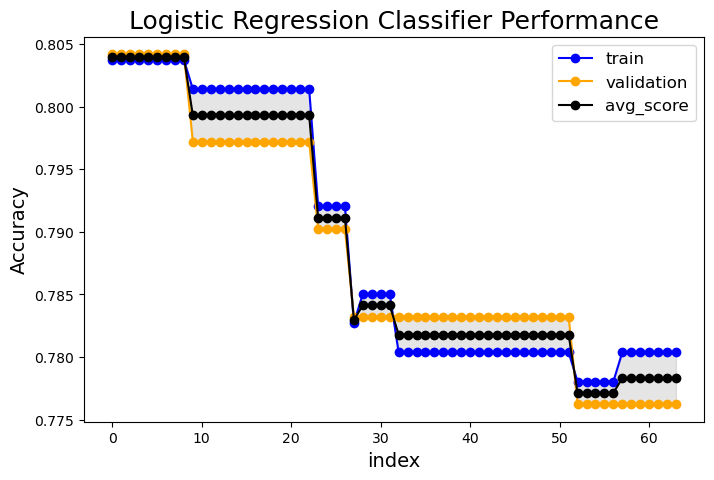

,features,c_value,train_score,val_score,diff_score,avg_score
0,"[pclass, age, alone, sex_male]",1.0,0.803738,0.804196,0.000457,0.803967
1,"[pclass, age, alone, sex_male]",10.0,0.803738,0.804196,0.000457,0.803967
2,"[pclass, age, alone, sex_male]",100.0,0.803738,0.804196,0.000457,0.803967
3,"[pclass, age, alone, sex_male]",1000.0,0.803738,0.804196,0.000457,0.803967
4,"[pclass, age, alone, sex_male, embarked_Q]",0.1,0.803738,0.804196,0.000457,0.803967
5,"[pclass, age, alone, sex_male, embarked_Q]",1.0,0.803738,0.804196,0.000457,0.803967
6,"[pclass, age, alone, sex_male, embarked_Q]",10.0,0.803738,0.804196,0.000457,0.803967
7,"[pclass, age, alone, sex_male, embarked_Q]",100.0,0.803738,0.804196,0.000457,0.803967
8,"[pclass, age, alone, sex_male, embarked_Q]",1000.0,0.803738,0.804196,0.000457,0.803967
9,"[pclass, age, sex_male]",1.0,0.801402,0.797203,0.004199,0.799302


In [31]:
df1 = score_plot(df,0.005,'val_score',0.77)
df1.head(10)

In [32]:
f = df1.features[0]
l_test = LogisticRegression(C=df1.c_value[0],random_state=42)
l_test.fit(Xtr[f],ytr)
baseline(ytr),l_test.score(Xtr[f],ytr),l_test.score(Xv[f],yv),l_test.score(Xt[f],yt)

((0.5934579439252337, 0),
 0.8037383177570093,
 0.8041958041958042,
 0.7972027972027972)

### **Bonus1** How do different strategies for handling the missing values in the age column affect model performance?

In [33]:
df = get_titanic_data()
# tr,v,t = prep_split_titanic_drp_age(df)
tr,v,t = prep_split_titanic_imp_age(df)
# tr,v,t = prep_split_titanic_drp_null_age(df)
tr.sample()

csv file found and loaded
data cleaned and prepped
data split
train -> (534, 12); 59.93%
validate -> (178, 12); 19.98%
test -> (179, 12); 20.09%


,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S
693,0,3,male,25.0,0,0,7.225,C,1,1,0,0


In [34]:
Xtr = tr.drop(columns=['survived','sex','embarked'])
Xv = v.drop(columns=['survived','sex','embarked'])
Xt = t.drop(columns=['survived','sex','embarked'])
ytr = tr.survived
yv = v.survived
yt = t.survived

In [35]:
# impute_age baseline = 0.6161048689138576
baseline(ytr)

(0.6161048689138576, 0)

In [36]:
features = ['age','fare','pclass']
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])
l.score(Xtr[features],ytr)

0.7116104868913857

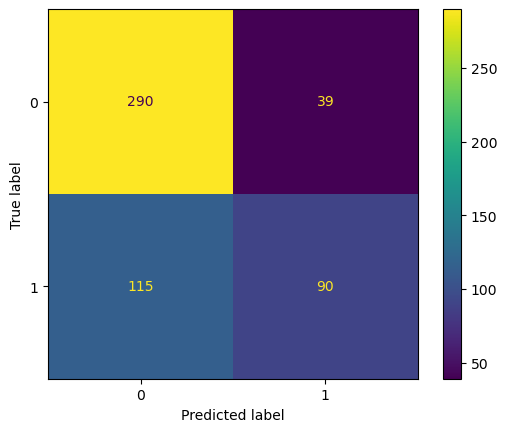

In [37]:
cmd(ytr,ytr_pred)

In [38]:
features = ['age','fare','pclass','sex_male']
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])
l.score(Xtr[features],ytr)

0.8014981273408239

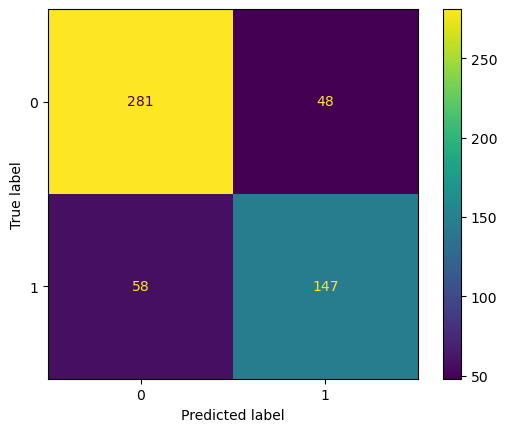

In [39]:
cmd(ytr,ytr_pred)

In [40]:
df = l_scores(Xtr,ytr,Xv,yv,max_iter=500)

In [41]:
df.sample()

,features,c_value,train_score,val_score,diff_score,avg_score
2234,"[pclass, age, sibsp, parch, fare, alone]",1.0,0.737828,0.730337,0.007491,0.734082


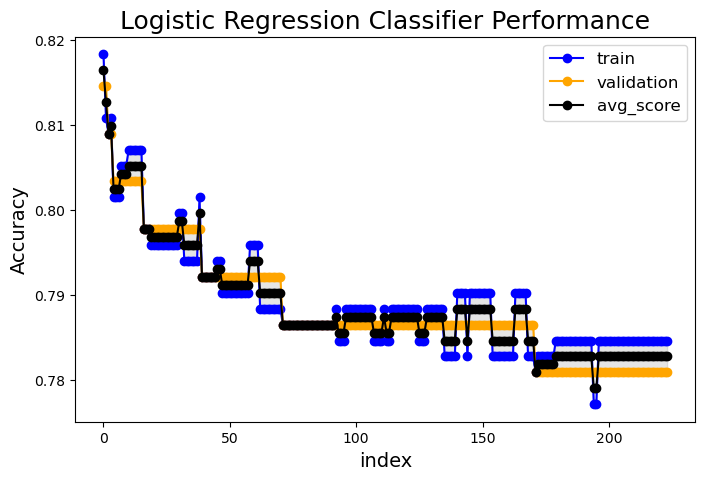

,features,c_value,train_score,val_score,diff_score,avg_score
0,"[pclass, age, alone, sex_male, embarked_Q]",0.1,0.818352,0.814607,0.003745,0.816479
1,"[pclass, age, sibsp, alone, sex_male, embarked...",0.1,0.810861,0.814607,0.003745,0.812734
2,"[pclass, age, sibsp, parch, alone, sex_male, e...",1.0,0.808989,0.808989,0.000000,0.808989
3,"[pclass, age, sibsp, alone, sex_male, embarked_S]",0.1,0.810861,0.808989,0.001873,0.809925
4,"[pclass, age, sibsp, alone, sex_male, embarked_S]",10.0,0.801498,0.803371,0.001873,0.802434
5,"[pclass, age, sibsp, alone, sex_male, embarked_S]",100.0,0.801498,0.803371,0.001873,0.802434
6,"[pclass, age, sibsp, alone, sex_male, embarked_S]",1000.0,0.801498,0.803371,0.001873,0.802434
7,"[pclass, age, sibsp, parch, alone, sex_male, e...",10.0,0.805243,0.803371,0.001873,0.804307
8,"[pclass, age, sibsp, parch, alone, sex_male, e...",100.0,0.805243,0.803371,0.001873,0.804307
9,"[pclass, age, sibsp, parch, alone, sex_male, e...",1000.0,0.805243,0.803371,0.001873,0.804307


In [42]:
sort = score_plot(df,0.005,'val_score',0.77)
sort.head(10)

In [43]:
f = sort.features[0]
l_test = LogisticRegression(C=sort.c_value[0],random_state=42)
l_test.fit(Xtr[f],ytr)
baseline(ytr),l_test.score(Xtr[f],ytr),l_test.score(Xv[f],yv),l_test.score(Xt[f],yt)

((0.6161048689138576, 0),
 0.8183520599250936,
 0.8146067415730337,
 0.7988826815642458)

In [44]:
df = get_titanic_data()
tr,v,t = prep_split_titanic_drp_age(df)
# tr,v,t = prep_split_titanic_imp_age(df)
# tr,v,t = prep_split_titanic_drp_null_age(df)
tr.sample()

csv file found and loaded
data cleaned and prepped
data split
train -> (534, 11); 59.93%
validate -> (178, 11); 19.98%
test -> (179, 11); 20.09%


,survived,pclass,sex,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S
104,0,3,male,2,0,7.925,S,0,1,0,1


In [45]:
Xtr = tr.drop(columns=['survived','sex','embarked'])
Xv = v.drop(columns=['survived','sex','embarked'])
Xt = t.drop(columns=['survived','sex','embarked'])
ytr = tr.survived
yv = v.survived
yt = t.survived

In [46]:
# drop_age baseline = 0.6161048689138576
baseline(ytr)

(0.6161048689138576, 0)

In [47]:
features = ['fare','pclass']
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])
l.score(Xtr[features],ytr)

0.700374531835206

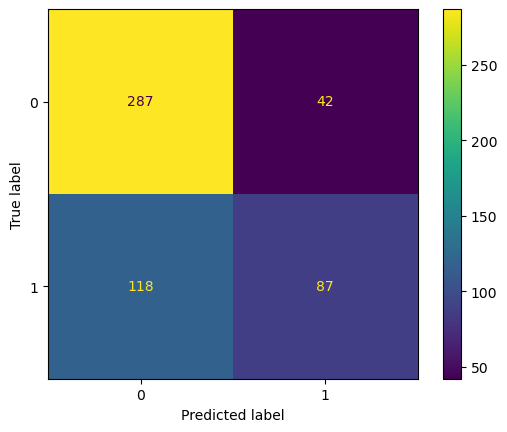

In [48]:
cmd(ytr,ytr_pred)

In [49]:
features = ['fare','pclass','sex_male']
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])
l.score(Xtr[features],ytr)

0.7846441947565543

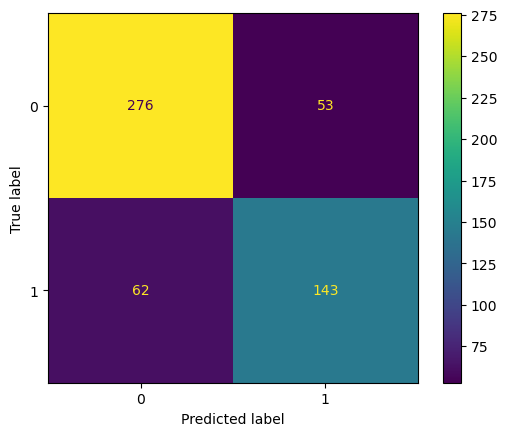

In [50]:
cmd(ytr,ytr_pred)

In [51]:
df = l_scores(Xtr,ytr,Xv,yv,max_iter=500)

In [52]:
df.sample()

,features,c_value,train_score,val_score,diff_score,avg_score
984,"[pclass, sibsp, fare, alone, sex_male]",0.01,0.722846,0.707865,0.014981,0.715356


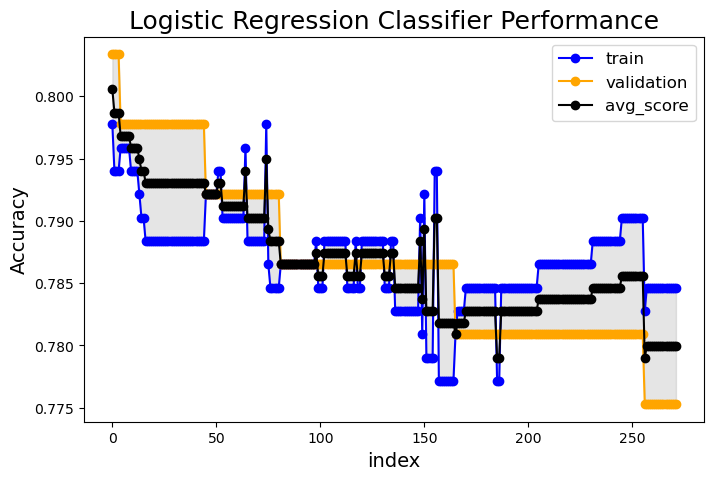

,features,c_value,train_score,val_score,diff_score,avg_score
0,"[pclass, fare, sex_male, embarked_Q, embarked_S]",0.1,0.797753,0.803371,0.005618,0.800562
1,"[sibsp, parch, alone, sex_male, embarked_S]",10.0,0.794007,0.803371,0.009363,0.798689
2,"[sibsp, parch, alone, sex_male, embarked_S]",100.0,0.794007,0.803371,0.009363,0.798689
3,"[sibsp, parch, alone, sex_male, embarked_S]",1000.0,0.794007,0.803371,0.009363,0.798689
4,"[pclass, sibsp, fare, sex_male]",0.1,0.795880,0.797753,0.001873,0.796816
5,"[pclass, fare, sex_male, embarked_S]",0.1,0.795880,0.797753,0.001873,0.796816
6,"[pclass, sibsp, fare, sex_male, embarked_Q]",0.1,0.795880,0.797753,0.001873,0.796816
7,"[pclass, parch, fare, sex_male, embarked_S]",0.1,0.795880,0.797753,0.001873,0.796816
8,"[pclass, parch, fare, sex_male, embarked_Q, em...",0.1,0.795880,0.797753,0.001873,0.796816
9,"[sibsp, parch, fare, alone, sex_male]",0.1,0.794007,0.797753,0.003745,0.795880


In [53]:
sort = score_plot(df,0.01,'val_score',0.77)
sort.head(10)

In [54]:
f = sort.features[4]
l_test = LogisticRegression(C=sort.c_value[0],random_state=42,max_iter=200)
l_test.fit(Xtr[f],ytr)
baseline(ytr),l_test.score(Xtr[f],ytr),l_test.score(Xv[f],yv),l_test.score(Xt[f],yt)

((0.6161048689138576, 0),
 0.795880149812734,
 0.797752808988764,
 0.8044692737430168)

### **Bonus2** How do different strategies for encoding sex affect model performance?

In [55]:
# like encoding gender as an order (1 & 2) vs 0 & 1
df = get_titanic_data()
df['gender'] = df.sex.map({'female': 1, 'male': 2})
tr,v,t = prep_split_titanic_imp_age(df)

csv file found and loaded
data cleaned and prepped
data split
train -> (534, 13); 59.93%
validate -> (178, 13); 19.98%
test -> (179, 13); 20.09%


In [56]:
tr.sample()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone,gender,sex_male,embarked_Q,embarked_S
188,0,3,male,40.0,1,1,15.5,Q,0,2,1,1,0


In [57]:
Xtr = tr.drop(columns=['survived','sex','embarked','sex_male'])
Xv = v.drop(columns=['survived','sex','embarked','sex_male'])
Xt = t.drop(columns=['survived','sex','embarked','sex_male'])
ytr = tr.survived
yv = v.survived
yt = t.survived

In [58]:
baseline(ytr)

(0.6161048689138576, 0)

In [59]:
features = ['age','fare','pclass']
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])
l.score(Xtr[features],ytr)

0.7116104868913857

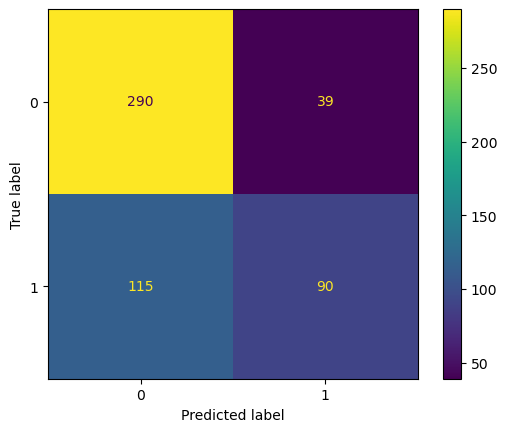

In [60]:
cmd(ytr,ytr_pred)

In [61]:
features = ['fare','pclass','gender']
l = LogisticRegression(random_state=42)
l.fit(Xtr[features],ytr)
ytr_pred = l.predict(Xtr[features])
l.score(Xtr[features],ytr)

0.7846441947565543

### Bonus3: scikit-learn's LogisticRegression classifier is actually applying a regularization penalty to the coefficients by default. This penalty causes the magnitude of the coefficients in the resulting model to be smaller than they otherwise would be. This value can be modified with the C hyper parameter. Small values of C correspond to a larger penalty, and large values of C correspond to a smaller penalty.
Try out the following values for C and note how the coefficients and the model's performance on both the dataset it was trained on and on the validate split are affected.
[.01,.1,1,10,100,1000]

In [62]:
# re-ran all with this